In [1]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [2]:
df =pd.read_sql_table('printer', 'sqlite:///dissertation.db') 

In [3]:
df_copy = df.copy()

In [4]:
# group by half an hour, and change kWh to Wh in order to enlarge the number
df_half = pd.DataFrame ({'Half_Wh':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [5]:
# prepare data for clustering
df_half['weekofyear']=df_half.index.week
df_half['day_categ']=df_half.index.day_name()
df_half['day_num']=df_half.index.weekday
#df_half['day']=df_half.index.day
df_half['hour']=df_half.index.hour


# prepare day_type --> weekday, weekend, holiday
df_half['day_type'] = df_half['day_num'].apply(lambda x: 'weekday' if x <5 else 'weekend')
df_half.loc[(df_half.index >= '2019-12-24 00:00:00') & (df_half.index < '2019-12-26 00:00:00'), 'day_type']='holiday'
df_half.loc[(df_half.index >= '2020-01-01 00:00:00') & (df_half.index < '2020-01-02 00:00:00'), 'day_type']='holiday'

# prepare morning, afternoon, and night 
df_half['time_of_day'] =df_half['hour'].apply(lambda x: 'morning' if (x>=7) & (x<= 12) else ('afternoon' if (x>12) & (x<=18) else 'night'))

# lockdown
df_half.loc[(df_half.weekofyear >=12) & (df_half.weekofyear <24), 'day_type'] = 'holiday'


df_half['hour']=df_half.index.strftime('%H')

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [56]:
# subset 80% of dataset for train and test, 20% for future input  
subset = 6451
df_train_test = df_half[['Half_Wh']][:subset]
df_simu = df_half[['Half_Wh']][subset:]

# transform 
train_test=df_train_test.values
train_test=train_test.astype('float32')

simu=df_simu.values
simu=simu.astype('float32')

In [87]:
# split into train and test sets
train_size = int(len(train_test) * 0.5)
test_size = len(train_test) - train_size
train, test = train_test[0:train_size], train_test[train_size:len(train_test)]
print(len(train), len(test))

3225 3226


In [88]:
# manipulate data to x,and y
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [89]:
look_back=96
trainX, trainY = create_dataset(train,look_back)
testX, testY = create_dataset(test,look_back)
simuX, simuY = create_dataset(simu,look_back)

In [46]:
# add extra variables day_type and time of the day

# extract the train variables for same length
df_train_var=df_half[['day_categ','time_of_day','day_type']][:len(trainX)]
# get dummies
df_dum_train=pd.get_dummies(df_train_var)

# extract the test variables for same length
df_test_var=df_half[['day_categ','time_of_day','day_type']][len(trainX):len(trainX)+len(testX)]
# get dummies
df_dum_test=pd.get_dummies(df_test_var)

# extract the validation variables for same length
df_simu_var=df_half[['day_categ','time_of_day','day_type']][len(trainX)+len(testX):len(trainX)+len(testX)+len(simuX)]
# get dummies
df_dum_simu=pd.get_dummies(df_simu_var)
df_dum_simu['day_type_weekday']=0
df_dum_simu['day_type_weekend']=0

In [47]:
#to np
np_train=np.array(df_dum_train)

#to np
np_test=np.array(df_dum_test)

#to np
np_simu=np.array(df_dum_simu)

In [48]:
#concatenate trainX, testX, validX with variables, respectively
trainX_ok = np.concatenate((trainX, np_train),axis=1)
testX_ok = np.concatenate((testX, np_test),axis=1)
simuX_ok = np.concatenate((simuX, np_simu),axis=1)

In [96]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(220, input_dim=look_back, activation='relu'))
#model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae','mape'])
history = model.fit(trainX, trainY, epochs=250, batch_size=10, verbose=2)

Epoch 1/250
 - 1s - loss: 214.7885 - mse: 214.7885 - mae: 9.1523 - mape: 23.5534
Epoch 2/250
 - 1s - loss: 145.8342 - mse: 145.8342 - mae: 7.0089 - mape: 17.1583
Epoch 3/250
 - 0s - loss: 138.2653 - mse: 138.2654 - mae: 6.7258 - mape: 16.2323
Epoch 4/250
 - 1s - loss: 136.7470 - mse: 136.7470 - mae: 6.8804 - mape: 16.8430
Epoch 5/250
 - 1s - loss: 128.9208 - mse: 128.9209 - mae: 6.4191 - mape: 15.3660
Epoch 6/250
 - 1s - loss: 133.4383 - mse: 133.4383 - mae: 6.6372 - mape: 16.0953
Epoch 7/250
 - 1s - loss: 125.3586 - mse: 125.3585 - mae: 6.1416 - mape: 14.4093
Epoch 8/250
 - 1s - loss: 128.1122 - mse: 128.1121 - mae: 6.3339 - mape: 15.1444
Epoch 9/250
 - 1s - loss: 121.2766 - mse: 121.2766 - mae: 6.0105 - mape: 13.9620
Epoch 10/250
 - 0s - loss: 121.6608 - mse: 121.6607 - mae: 5.9531 - mape: 13.8614
Epoch 11/250
 - 1s - loss: 122.2683 - mse: 122.2683 - mae: 6.1019 - mape: 14.3730
Epoch 12/250
 - 1s - loss: 122.9092 - mse: 122.9092 - mae: 6.1609 - mape: 14.5218
Epoch 13/250
 - 0s - loss

Epoch 103/250
 - 1s - loss: 59.0737 - mse: 59.0737 - mae: 4.1372 - mape: 9.5342
Epoch 104/250
 - 1s - loss: 53.4691 - mse: 53.4691 - mae: 3.9017 - mape: 8.9608
Epoch 105/250
 - 1s - loss: 54.0279 - mse: 54.0278 - mae: 4.1453 - mape: 9.8438
Epoch 106/250
 - 1s - loss: 55.2404 - mse: 55.2404 - mae: 4.0425 - mape: 9.4501
Epoch 107/250
 - 1s - loss: 52.6718 - mse: 52.6718 - mae: 3.8664 - mape: 9.0045
Epoch 108/250
 - 1s - loss: 55.9699 - mse: 55.9699 - mae: 4.1756 - mape: 9.8118
Epoch 109/250
 - 1s - loss: 57.3099 - mse: 57.3099 - mae: 4.1542 - mape: 9.7333
Epoch 110/250
 - 1s - loss: 52.0291 - mse: 52.0291 - mae: 3.8914 - mape: 9.0700
Epoch 111/250
 - 1s - loss: 58.5188 - mse: 58.5188 - mae: 4.1824 - mape: 9.7556
Epoch 112/250
 - 1s - loss: 54.2510 - mse: 54.2510 - mae: 4.0132 - mape: 9.3168
Epoch 113/250
 - 1s - loss: 56.5163 - mse: 56.5163 - mae: 4.0897 - mape: 9.5054
Epoch 114/250
 - 1s - loss: 50.3044 - mse: 50.3044 - mae: 3.8454 - mape: 8.9831
Epoch 115/250
 - 1s - loss: 48.2951 - ms

Epoch 206/250
 - 1s - loss: 32.4651 - mse: 32.4651 - mae: 3.0538 - mape: 7.2100
Epoch 207/250
 - 1s - loss: 32.1707 - mse: 32.1707 - mae: 3.0442 - mape: 7.1941
Epoch 208/250
 - 1s - loss: 31.8562 - mse: 31.8562 - mae: 3.0305 - mape: 7.2313
Epoch 209/250
 - 1s - loss: 30.3870 - mse: 30.3870 - mae: 2.9665 - mape: 7.0935
Epoch 210/250
 - 1s - loss: 34.0111 - mse: 34.0111 - mae: 3.2760 - mape: 7.8821
Epoch 211/250
 - 1s - loss: 32.9939 - mse: 32.9939 - mae: 3.1325 - mape: 7.5365
Epoch 212/250
 - 1s - loss: 31.9945 - mse: 31.9945 - mae: 2.9755 - mape: 7.0700
Epoch 213/250
 - 1s - loss: 31.4192 - mse: 31.4192 - mae: 3.0156 - mape: 7.0916
Epoch 214/250
 - 1s - loss: 30.3393 - mse: 30.3393 - mae: 2.9140 - mape: 6.9102
Epoch 215/250
 - 1s - loss: 30.4992 - mse: 30.4992 - mae: 3.0512 - mape: 7.4237
Epoch 216/250
 - 1s - loss: 33.7266 - mse: 33.7266 - mae: 3.2245 - mape: 7.6617
Epoch 217/250
 - 1s - loss: 31.7353 - mse: 31.7353 - mae: 3.0437 - mape: 7.2265
Epoch 218/250
 - 1s - loss: 30.2533 - ms

In [97]:
# model evalute
trainScore = model.evaluate(trainX, trainY)
testScore = model.evaluate(testX, testY)
#validScore = model.evaluate(validX, validY)

print('Train MSE: ', trainScore[1], 'MAE: ', trainScore[2])
print('Test MSE: ', testScore[1], 'MAE: ', testScore[2])

3129/3129 [==============================] - 0s 45us/step
Train MSE:  26.4326114654541 MAE:  2.8567066192626953
Test MSE:  52.905914306640625 MAE:  2.6872100830078125


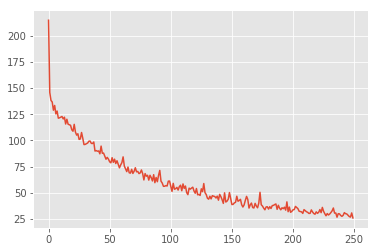

In [98]:
plt.plot(history.history['loss'])

In [99]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
simuPredict = model.predict(simuX)
nextPredict = model.predict(testX[-1:,:])

In [100]:
print(nextPredict,df_simu[0:1].values)

[[26.791155]] [[28.]]


In [101]:
from sklearn.metrics import r2_score
r2_score(testY,testPredict)

0.47649241354976435

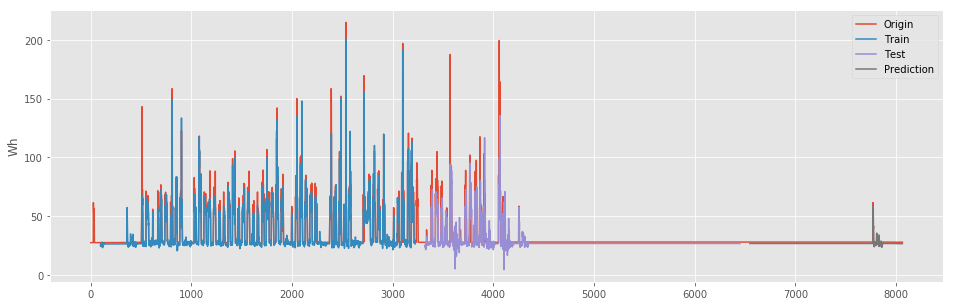

In [102]:
trainPredictPlot = np.empty_like(train_test)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(train_test)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(train_test)-1, :] = testPredict

np_all = np.concatenate((train_test,simu),axis=0)
simuPredictPlot = np.empty_like(np_all)
simuPredictPlot[:, :] = np.nan
simuPredictPlot[len(train_test)+look_back:-1, :] = simuPredict


#add time range

# plot baseline and predictions
plt.figure(figsize=(16,5))
plt.plot(np_all,label='Origin')
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Test')
plt.plot(simuPredictPlot,label='Prediction')
plt.legend()
plt.ylabel('Wh')
plt.show()

In [103]:
# plot graph with time in xaxis, add time and plot
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_all = pd.DataFrame(np_all,columns={'Actual'}).set_index(time_index)
df_trainPredictPlot = pd.DataFrame(trainPredictPlot,columns={'Train'}).set_index(time_index[:subset])
df_testPredictPlot = pd.DataFrame(testPredictPlot,columns={'Test'}).set_index(time_index[:subset])
df_simuPredictPlot = pd.DataFrame(simuPredictPlot,columns={'Prediction'}).set_index(time_index)
df_all_plot = pd.concat([df_all, df_trainPredictPlot,df_testPredictPlot,df_simuPredictPlot], axis=1)

Text(0, 0.5, 'Wh')

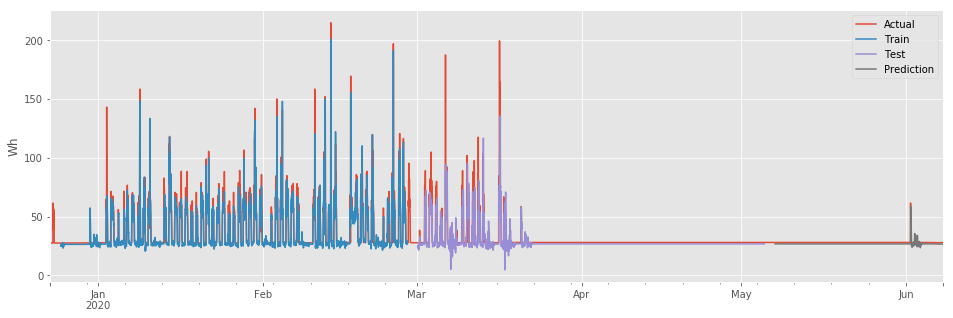

In [104]:
df_all_plot.set_index(df_all_plot.index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

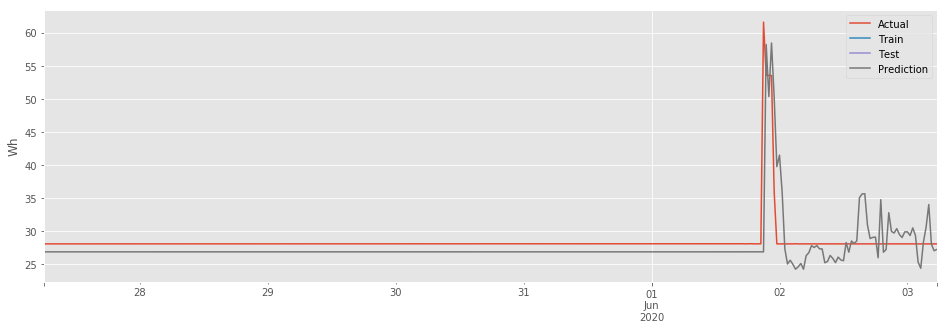

In [105]:
df_all_plot[7500:7836].set_index(df_all_plot[7500:7836].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

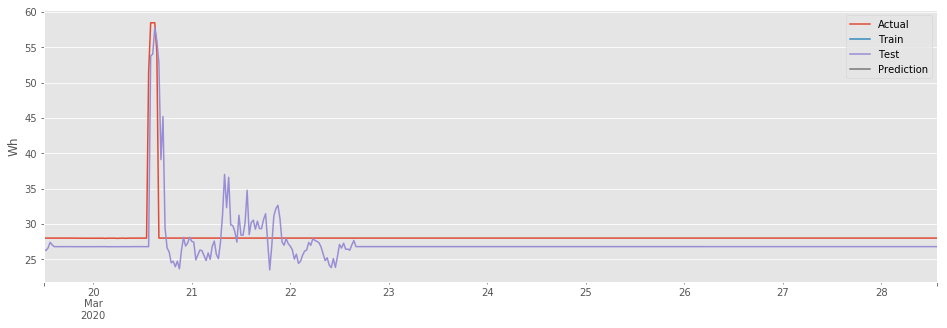

In [106]:
df_all_plot[4200:4636].set_index(df_all_plot[4200:4636].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

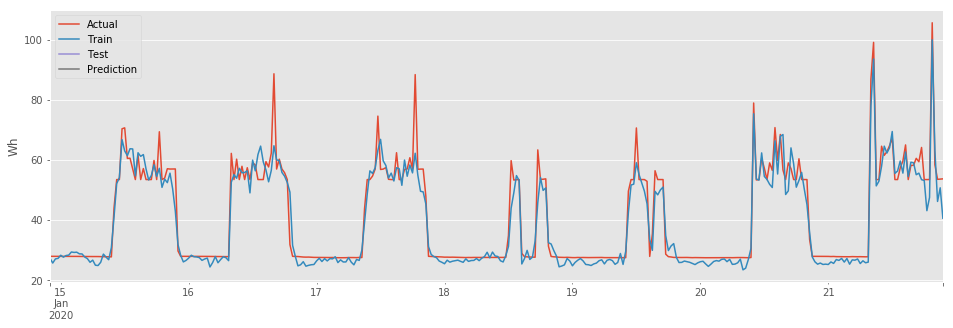

In [107]:
df_all_plot[1100:1436].set_index(df_all_plot[1100:1436].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [108]:
# save the model 
model.save('printer_ann.h5')

In [5]:
# with lockdown
mad_mean_ratio =2.687*3226/df_half['Half_Wh'][6451-3226:6451].sum() 
mad_mean_ratio

0.08856020649217665